In [126]:
using Pkg

Pkg.activate("..")

using Revise

In [127]:
using DifferentialEquations
using Plots
using MetabolicSim
using Random

In [128]:
N,M = 50,50

#consumers
u = rand(N,M)
Rm = sum(u,dims=2)[:,1]

#resources
l = rand(M,M)
[l[i,j] = i <= j ? l[i,j] : 0.0 for i = 1:M, j = 1:M]
[l[i,:] .= 0.5 * (l[i,:] / sum(l[i,:])) for i = 1:M]
ρ = ones(M)
ω = fill(0.1,M)

#make params
p = make_parameters(N,M,u,Rm,l,ρ,ω)
x0 = ones(N+M)


prob = ODEProblem(dx!,x0,(0.0,100.0),p)
sol = solve(prob)

c = vcat(fill(:red,M), fill(:blue,N)...)
c = reshape(c, (1, N+M))
plot(sol, legend = false, color = c)


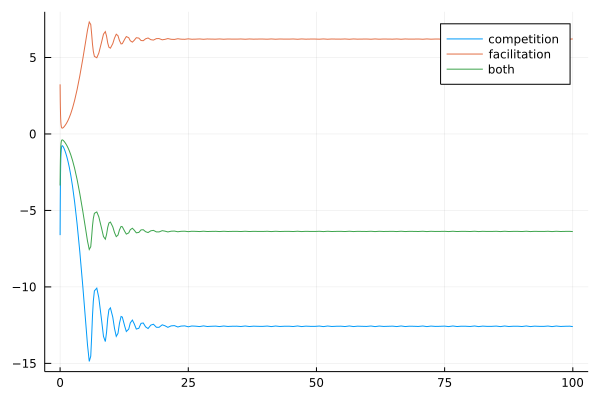

In [130]:
using Statistics

a_comp = mean.(MetabolicSim.get_resource_a.(Ref(sol), sol.t, :competition))
a_facil = mean.(MetabolicSim.get_resource_a.(Ref(sol), sol.t, :facilitation))
a_tot = mean.(MetabolicSim.get_resource_a.(Ref(sol), sol.t, :both))

plot(sol.t, a_comp, label = "competition")
plot!(sol.t, a_facil, label = "facilitation")
plot!(sol.t, a_tot, label = "both")

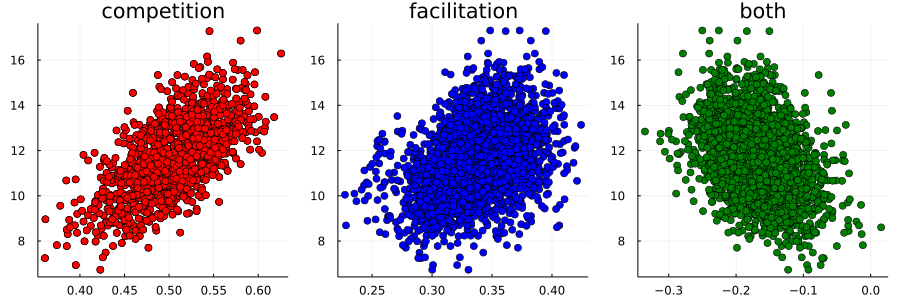

In [111]:
#calculate interactions
#overlap methods
comp_overlap = get_overlap_competition(sol)
facil_overlap = get_overlap_facilitation(sol)
both_overlap = facil_overlap .- comp_overlap 

#resource explicit methods
comp_res = get_resource_a(sol, sol.t[end], :competition)
facil_res = get_resource_a(sol, sol.t[end], :facilitation)
both_res = get_resource_a(sol, sol.t[end], :both)

indx = (comp_overlap .!= 1.0)[:]


p1 = scatter(comp_overlap[:][indx], comp_res[:][indx], legend = false, color = "red", title = "competition")
p2 = scatter(facil_overlap[:][indx], comp_res[:][indx], legend = false, color = "blue", title = "facilitation")
p3 = scatter(both_overlap[:][indx], comp_res[:][indx], legend = false, color = "green", title = "both")

plot(p1,p2,p3, layout = (1,3), size = (900, 300))

In [112]:
#generating u and l structures
consumer_θ = sort(rand(N))
resource_θ = sort(rand(M))
    
#constructing u - use gaussian function of distance
σ = 0.1
θ_min = 0.5

u = exp.( (-abs.(consumer_θ .- resource_θ').^2)/ σ )
u[u .< θ_min] .= 0.0;

In [113]:
#constructing l - gaussian function of distance, bounded leftward at 0
l_dist = resource_θ .- resource_θ'
zero_indx = (l_dist .> 0.0)

σ = 0.1
l̄ = 0.5

l = exp.(-( (l_dist .+ l̄).^2) ./ σ )
l[zero_indx] .= 0.0
[l[i,:] .= 0.3 * l[i,:]./sum(l[i,:]) for i = 1:M ];

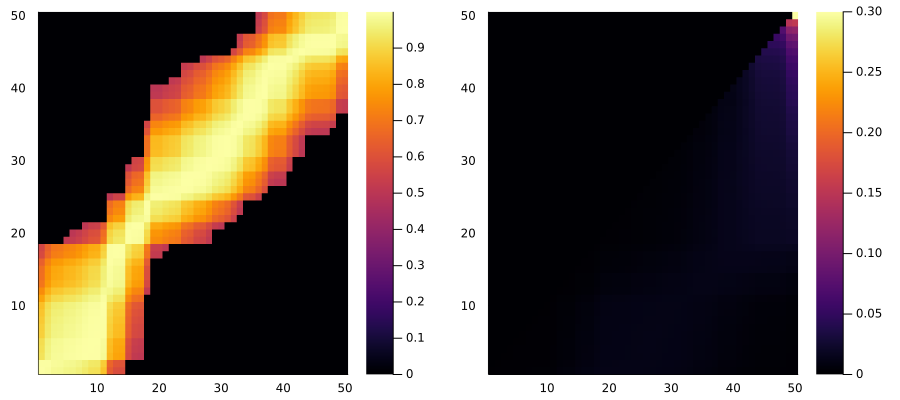

In [114]:
plot(heatmap(u), heatmap(l), size = (900,400))

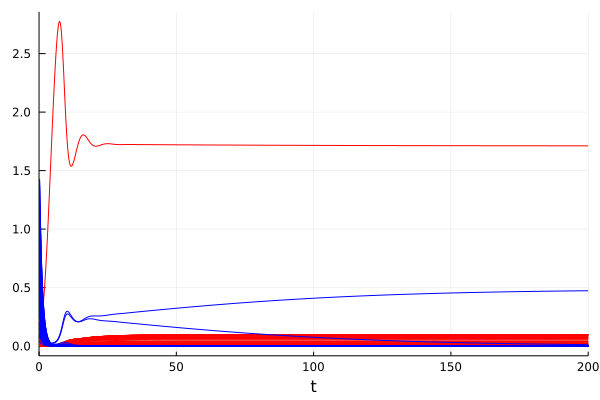

In [115]:
#make params
Rm = sum(u,dims = 2)[:] ./ 10
ρ = zeros(M)
ρ[1] = 1.0

p = make_parameters(N,M,u,Rm,l,ρ,fill(0.1, M))
x0 = rand(N+M)
tspan = (0.0, 200)
prob = ODEProblem(MetabolicSim.dx!, x0, tspan, p)
sol = solve(prob)

c = vcat(fill(:red,M), fill(:blue,N)...)
c = reshape(c, (1, N+M))
plot(sol, legend = false, color = c)

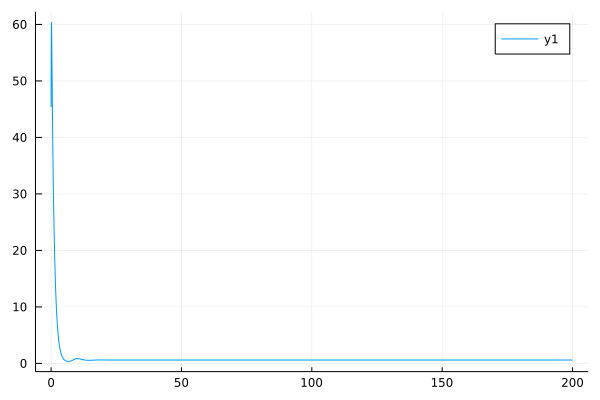

In [116]:
plot(sol.t, get_R.(Ref(sol),sol.t))

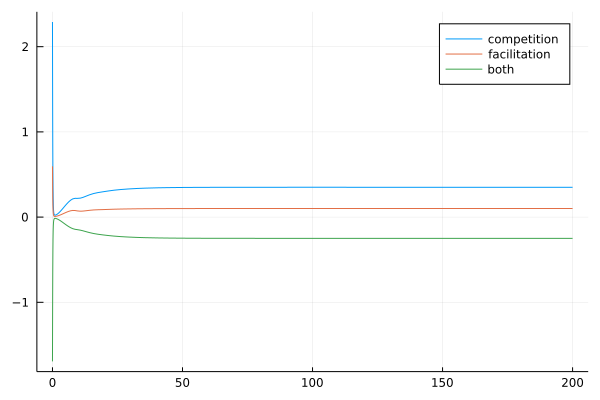

In [117]:
a_comp = mean.(MetabolicSim.get_resource_a.(Ref(sol), sol.t, :competition))
a_facil = mean.(MetabolicSim.get_resource_a.(Ref(sol), sol.t, :facilitation))
a_tot = mean.(MetabolicSim.get_resource_a.(Ref(sol), sol.t, :both))

plot(sol.t, a_comp, label = "competition")
plot!(sol.t, a_facil, label = "facilitation")
plot!(sol.t, a_tot, label = "both")

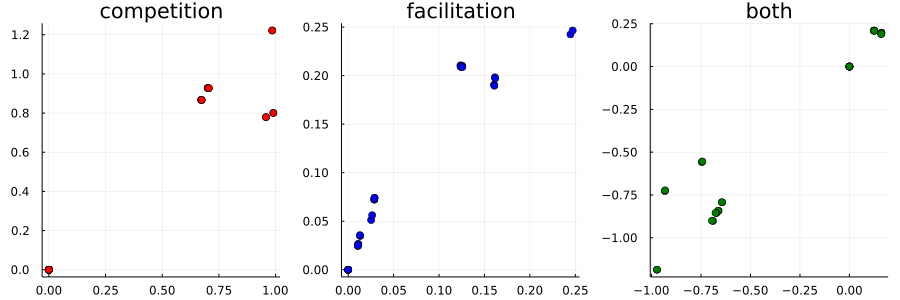

In [118]:
#calculate interactions
#extant
ext = sol[end][(M+1):end] .> eps()

#overlap methods
comp_overlap = get_overlap_competition(sol)[ext,ext]
facil_overlap = get_overlap_facilitation(sol)[ext,ext]
both_overlap = (facil_overlap .- comp_overlap)

#resource explicit methods
comp_res = get_resource_a(sol, sol.t[end], :competition)[ext,ext]
facil_res = get_resource_a(sol, sol.t[end], :facilitation)[ext,ext]
both_res = get_resource_a(sol, sol.t[end], :both)[ext,ext]

# #non-intra interactions
indx = (comp_overlap .!= 1.0)[:]


p1 = scatter(comp_overlap[:][indx], comp_res[:][indx], legend = false, color = "red", title = "competition")
p2 = scatter(facil_overlap[:][indx], facil_res[:][indx], legend = false, color = "blue", title = "facilitation")
p3 = scatter(both_overlap[:][indx], both_res[:][indx], legend = false, color = "green", title = "both")

plot(p1,p2,p3, layout = (1,3), size = (900, 300))

In [119]:
function generate_parameters(N,M)
    #generating u and l structures
    consumer_θ = sort(rand(N))
    resource_θ = sort(rand(M))

    #constructing u - use gaussian function of distance
    σ = 0.1
    θ_min = 0.5

    u = exp.( (-abs.(consumer_θ .- resource_θ').^2)/ σ )
    u[u .< θ_min] .= 0.0;
    
    #constructing l - gaussina function of distance, bounded leftward at 0
    l_dist = resource_θ .- resource_θ'
    zero_indx = (l_dist .> 0.0)

    σ = 0.1
    l̄ = 0.5

    l = exp.(-( (l_dist .+ l̄).^2) ./ σ )
    l[zero_indx] .= 0.0
    [l[i,:] .= 0.3 * l[i,:]./sum(l[i,:]) for i = 1:M ];
    
    Rm = sum(u,dims = 2)[:] ./ 10
    ρ = zeros(M)
    ρ[1] = 1.0
    ω = fill(0.1, M)

    p = make_parameters(N,M,u,Rm,l,ρ,ω)
    return(p)
end

generate_parameters (generic function with 1 method)

In [120]:
N_sim = 10

res = Vector{Any}(undef,N_sim)

for i = 1:N_sim
    print(i)
    p = generate_parameters(N,M)
    x0 = rand(N+M)
    tspan = (0.0, 1e4)
    prob = ODEProblem(MetabolicSim.dx_threaded!, x0, tspan, p)
    res[i] = solve(prob)
end

12345678910

In [122]:
#test for degree of resource equilibrium
t_end = 1e4
t_start = t_end * 0.9

function coefficent_variation(x)
    std(x) / mean(x)
end

#largest coeffient of variation
[maximum(mapslices(coefficent_variation,hcat(res[i].(t_start:1.0:t_end)...),dims = 2)) for i = 1:N_sim]

10-element Vector{Float64}:
    0.899812493986169
 4281.334309864087
    9.145096571324657
    1.1580780240297852
    0.7270684276951505
    8.93556083272822
    4.675018346404994
    4.645220392493558
   10.184046528240959
    4.09530293717664

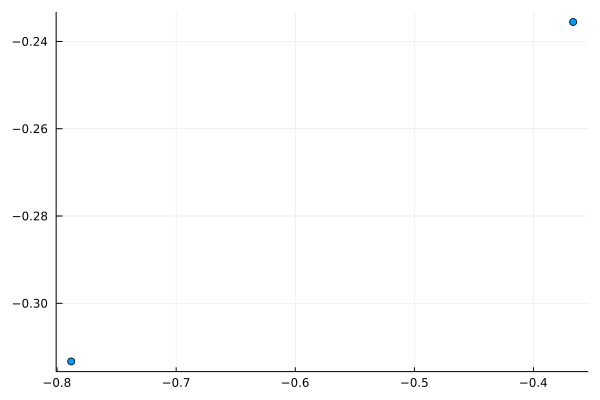

In [66]:
using StatsPlots

a_extant = Vector{Float64}(undef,N_sim)
sd_extant = Vector{Float64}(undef,N_sim)
a_extinct = Vector{Float64}(undef,N_sim)
sd_extinct = Vector{Float64}(undef,N_sim)

for i = 1:N_sim
    sol = res[i]
    extant = sol[end][(M+1):end] .> eps()
    extinct = sol[end][(M+1):end] .<= eps()
    
    a = get_resource_a(sol, sol.t[end], :both)
    a_extant[i] = mean(a[extant,extant][:])
    a_extinct[i] = mean(a[extinct,extinct][:])
    
    sd_extant[i] = std(a[extant,extant][:])
    sd_extinct[i] = std(a[extinct,extinct][:])
end

scatter(a_extant,a_extinct, legend = false)
Plots.abline!(1,0)

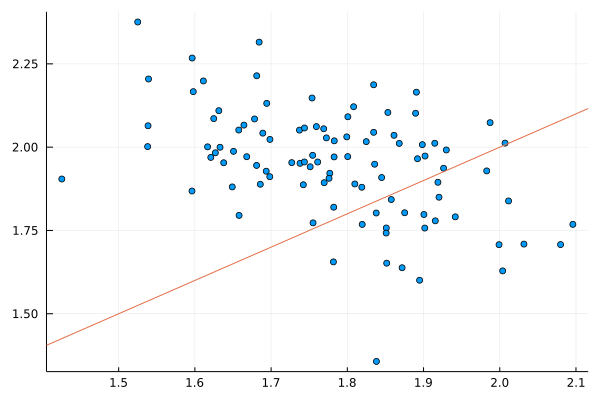

In [266]:
#Rm
using StatsPlots

Rm_extant = Vector{Float64}(undef,N_sim)
sd_extant = Vector{Float64}(undef,N_sim)
Rm_extinct = Vector{Float64}(undef,N_sim)
sd_extinct = Vector{Float64}(undef,N_sim)

for i = 1:N_sim
    sol = res[i]
    extant = sol[end][(M+1):end] .> eps()
    extinct = sol[end][(M+1):end] .<= eps()
    
    Rm = sol.prob.p.Rm
    Rm_extant[i] = mean(Rm[extant])
    Rm_extinct[i] = mean(Rm[extinct])
    
    sd_extant[i] = std(Rm[extant])
    sd_extinct[i] = std(Rm[extinct])
end

scatter(Rm_extant,Rm_extinct, legend = false)
Plots.abline!(1,0)

In [125]:
get_R.(res,t_end),get_ω.(res,t_end)

([0.5788226269779254, 0.6056050523720202, 0.6103440145018211, 0.583738341011543, 0.5785613780616841, 0.5716699742284282, 0.6231662166985522, 0.5985494659863172, 0.6153520356102555, 0.617991914721078], [0.42117710805504016, 0.3943949474773384, 0.38965651484441555, 0.4162621753163115, 0.42143887314112827, 0.4283312905673761, 0.37683478619713967, 0.4014501445520112, 0.3846482598911189, 0.3820079441645655])

10000